In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor,fidelity,tracedist,brmesolve,Qobj)
from qutip.solver import heom
from scipy.integrate import quad
from pseudomode import pseudomode,zero_temp_bath,rotation
from hamiltonians import syk_full,plot_ground,plot_fidelities,plot_trd,plot_positivity,plot_populations,plot_ground_comparison
from nmm import csolve,redfield

In [2]:
N=2
seeds=list(range(42,50))
k=0
H,psis=syk_full(N,seed=seeds[k],mu=0)

In [3]:
H

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[-0.22267004  0.          0.          0.        ]
 [ 0.          0.22267004  0.          0.        ]
 [ 0.          0.          0.22267004  0.        ]
 [ 0.          0.          0.         -0.22267004]]

In [4]:
Q=sum([(1/2 +1/(2*i+2))*psis[i] for i in range(len(psis))])
Q

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[ 0.        +0.j          0.53033009-0.70710678j  0.44194174-0.47140452j
   0.        +0.j        ]
 [ 0.53033009+0.70710678j  0.        +0.j          0.        +0.j
  -0.44194174+0.47140452j]
 [ 0.44194174+0.47140452j  0.        +0.j          0.        +0.j
   0.53033009-0.70710678j]
 [ 0.        +0.j         -0.44194174-0.47140452j  0.53033009+0.70710678j
   0.        +0.j        ]]

In [5]:
H=20*H

In [6]:
(H).eigenenergies()

array([-4.45340087, -4.45340087,  4.45340087,  4.45340087])

In [7]:
E01=H.eigenenergies()[2]-H.eigenenergies()[0]#it is mostly degenerate, this does not help much
print(E01) 
w0=1.1 *E01#since I have no g parameter then It doesn't scale uniformingly as ising
print(w0)
gamma=w0/2.05
print(gamma)
print(2*w0>gamma)
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2)
lam=np.sqrt(Omega)
lam

8.906801743340235
9.79748191767426
4.779259472036225
True


3.082465854213903

In [8]:
state_list = [basis(2, 1)] + [-1j*basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list2 = [basis(2, 1)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list.reverse()
psi0 = (tensor(state_list)+tensor(state_list2))/np.sqrt(2)
rho0=psi0*psi0.dag()
H.dims=rho0.dims
Q.dims=rho0.dims
times=np.linspace(0,50,500)
tfit=np.linspace(0, 40, 2000)

In [9]:
bath = heom.UnderDampedBath(
        Q=Q,
        lam=lam, gamma=gamma, w0=w0, T=0, Nk=5) # fix runtime warning
cfiitter2 = heom.CorrelationFitter(
    Q, 0, tfit, bath.correlation_function)
bath1, fit2info = cfiitter2.get_fit(Ni=1, Nr=2)
# notice one mode is also a pretty good approximation
print(fit2info['summary'])

/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:925: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om + 1.0j * Gamma) / 2)),
/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:927: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om - 1.0j * Gamma) / 2)),


Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         | 5.17e-01 |-2.44e+00 |9.48e+00                              | 1         |-5.00e-01 |-2.39e+00 |9.50e+00                              
 2         |-9.21e-02 |-8.95e+00 |2.13e-08                              |                                                                        
                                                                        |A  normalized RM

In [10]:
times2 = np.linspace(0,40,500)
cvis = bath.correlation_function(times2)

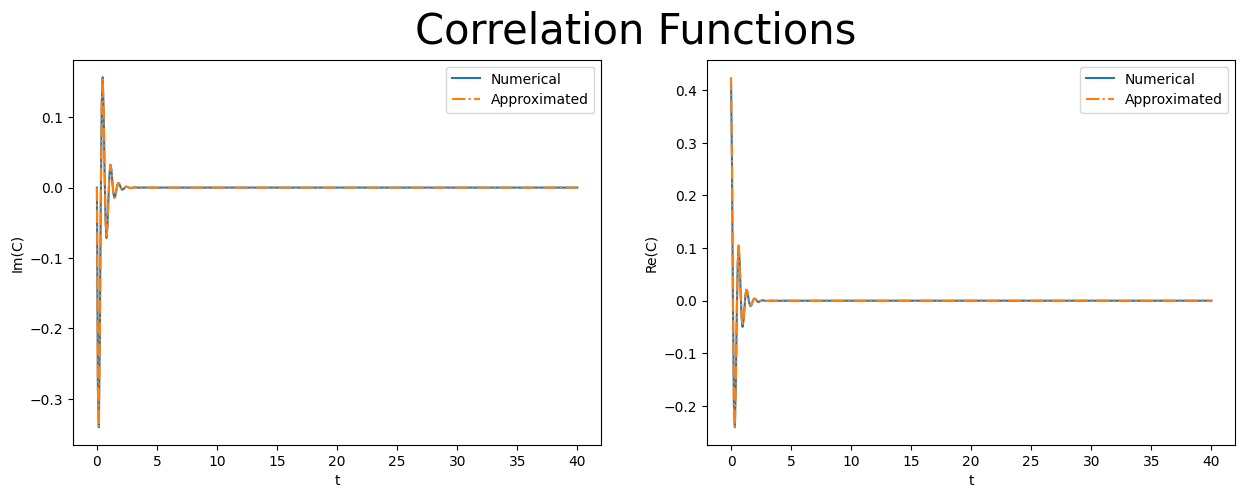

In [11]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(times2, np.imag(cvis),label="Numerical")
axs[0].plot(times2, np.imag(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(times2, np.real(cvis),label="Numerical")
axs[1].plot(times2, np.real(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [12]:
solver = heom.HEOMSolver(H,
                          [bath1], max_depth=5, options={"atol": 1e-14,"nsteps":100000})
result = solver.run(rho0, times)

10.0%. Run time:   1.64s. Est. time left: 00:00:00:14
20.0%. Run time:   3.32s. Est. time left: 00:00:00:13
30.1%. Run time:   4.85s. Est. time left: 00:00:00:11
40.1%. Run time:   6.57s. Est. time left: 00:00:00:09
50.1%. Run time:   8.19s. Est. time left: 00:00:00:08
60.1%. Run time:  10.51s. Est. time left: 00:00:00:06
70.1%. Run time:  12.43s. Est. time left: 00:00:00:05
80.2%. Run time:  14.09s. Est. time left: 00:00:00:03
90.2%. Run time:  16.01s. Est. time left: 00:00:00:01
100.0%. Run time:  18.11s. Est. time left: 00:00:00:00
Total run time:  18.11s


In [13]:
# red = redfield.redfield(
#     Hsys=H, t=times, baths=[bath],
#     Qs=[Q],
#     eps=1e-4,matsubara=False)

# result_red = red.evolution(rho0)

#result_red = rotation(result_red, H, times)

In [14]:
# result_red=[Qobj(i) for i in result_red]

In [15]:
# for i in result_red:
#     i.dims=H.dims

In [16]:
# result_red = rotation(result_red, H, times)

In [17]:
cum = csolve(
    Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-4, cython=False)

result_cum = cum.evolution(rho0)

result_cum = rotation(result_cum, H, times)

Computing Exponential of Generators . . . .: 100%|████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1394.13it/s]


In [18]:
a_ops = [[Q, bath.power_spectrum]]
resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14}, sec_cutoff=-1)

a_ops = [[Q, bath.power_spectrum]]
resultBR2 = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14})

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-2.18e-02 |-2.90e+00 |7.82e-10                              | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                              
 2         |-5.51e-02 |-1.41e+01 |1.83e-09                              |                                                                        
                                                                        |A  normalized RM

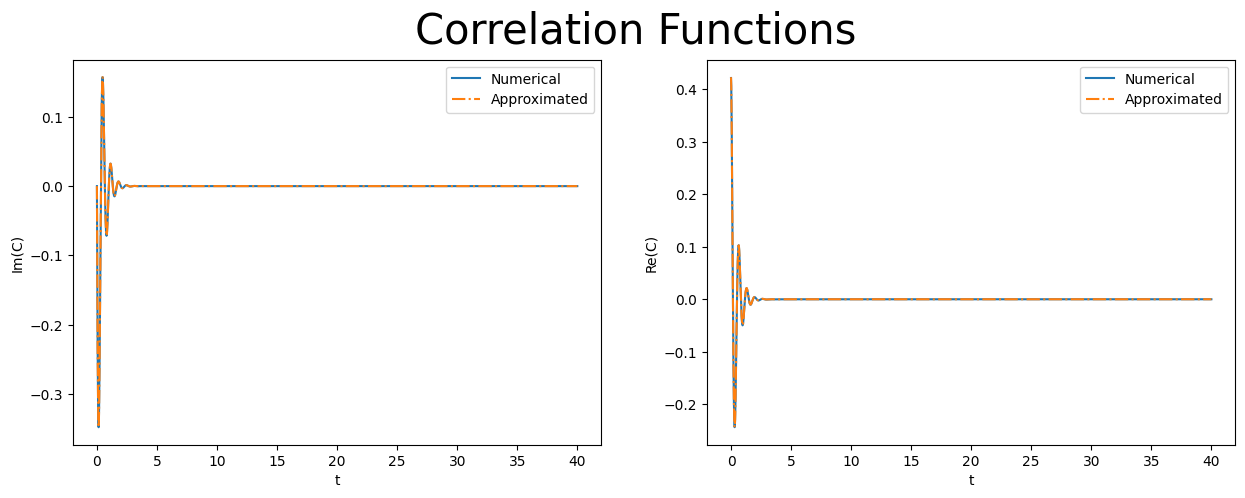

In [19]:
Ncutoff=3
modes=2
bathu = zero_temp_bath(Q, tfit, lam, gamma, w0, N=modes)
example = pseudomode(Hsys=H, Q=Q, bath=bathu)
print(bathu.finfo["summary"])
cvis2 = bathu.correlation_function
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(tfit, np.imag(cvis2),label="Numerical")
axs[0].plot(tfit, np.imag(bathu.bath.correlation_function_approx(tfit))+np.imag(bathu.C0(tfit, lam, gamma, w0)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(tfit, np.real(cvis2),label="Numerical")
axs[1].plot(tfit, np.real(bathu.bath.correlation_function_approx(tfit)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [20]:
ans = example.evolution(rho0, Ncutoff, times, options={ "normalize_output": False, "store_states": True})
ans = [i.ptrace(range(N))for i in ans.states]

In [21]:
results=[result,result_cum,resultBR,resultBR2,ans]

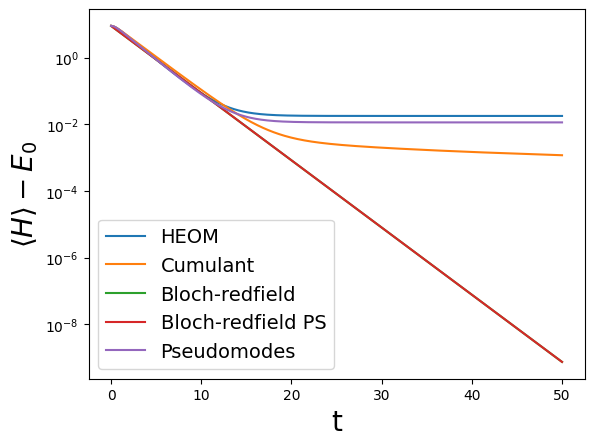

In [22]:
plot_ground(results,H,times)

In [23]:
def plot_fidelities(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Pseudomodes","Redfield"]
    style=["solid","solid","dashed","dashdot",'dashed',"solid"]
    for k,i in enumerate(states[1:],1):
        if "Bloch" in  labels[k]:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        else:
            try:
                sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
            except:
                sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

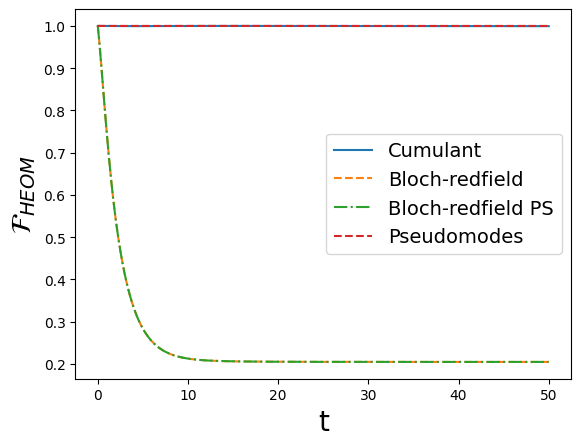

In [24]:
plot_fidelities(results,H,times)

In [25]:

def plot_trd(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Pseudomodes"]
    style=["solid","solid","dashed","dashdot",'dashed']

    for k,i in enumerate(states[1:],1):
        if "Bloch" in  labels[k]:
            sdd=np.array([tracedist(i.states[j],states[0].states[j]) for j in range(len(times))])
        else:
            try:
                sdd=np.array([tracedist(i.states[j],states[0].states[j]) for j in range(len(times))])
            except:
                sdd=np.array([tracedist(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,1-sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$1-\mathcal{Tr}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

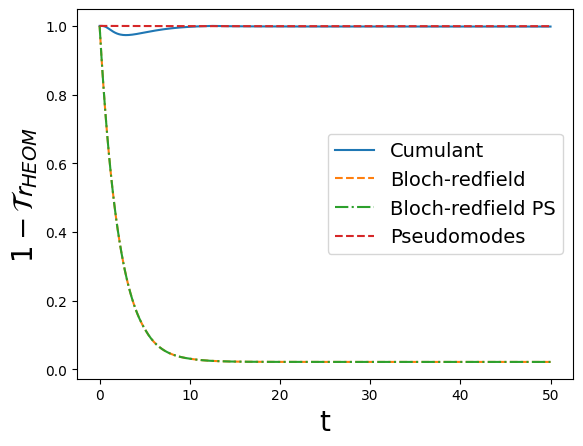

In [26]:
plot_trd(results,H,times)

In [27]:
def plot_populations(states,H,times,l=0,m=0):
    #labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Pseudomodes","Redfield"]
    labels=["RED","CUM"]
    for k,i in enumerate(states):
        try:
            sdd=np.array([j[l,m] for j in i.states])
        except:
            sdd=np.array([j[l,m] for j in i])
 
        plt.plot(times,sdd,label=labels[k])
    plt.legend(fontsize=14)
    plt.ylabel(rf"$\rho_{l,m}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()


In [28]:
others=[result_red,result_cum]

NameError: name 'result_red' is not defined

In [ ]:
plot_populations(others,H,times,l=3,m=0)
plt.show()

In [ ]:
result_red[-1].eigenenergies()

In [ ]:
result_cum[-1].eigenenergies()

In [ ]:
result.states[-1].eigenenergies()

In [ ]:
def plot_positivity(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Pseudomodes","Redfield"]
    for k,i in enumerate(states):
        try:
            sdd=np.array([np.min(i.states[j].eigenenergies()) for j in range(len(times))])
        except:
            sdd=np.array([np.min(i[j].eigenenergies())  for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k])
   # plt.ylim(-1e-3,0.001)
    plt.legend(fontsize=14)
    plt.ylabel(r"$min |E_i|$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()


In [ ]:
plot_positivity(results,H,times)

In [ ]:
def plot_ground_comparison(H,results):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Pseudomodes","Redfield"]
    style=["solid","dotted","dashed","dashdot",'dotted',"solid"]
    fig, axs = plt.subplots(1, 3,figsize=(25,5))
    rho00=(H.eigenstates()[1][0]* H.eigenstates()[1][0].dag())/(H.eigenstates()[1][0]* H.eigenstates()[1][0].dag()).tr()
    rho01=(H.eigenstates()[1][1]* H.eigenstates()[1][1].dag())/(H.eigenstates()[1][1]* H.eigenstates()[1][1].dag()).tr()
    ground=(rho01+rho00)/2
    t=results[0].times
    for k,result in enumerate(results):
        if "Bloch" in  labels[k]:
            f=[fidelity(result.states[i].conj(),rho00) for i in range(len(results[0].states))]
            f2=[fidelity(result.states[i].conj(),rho01) for i in range(len(results[0].states))]
            f3=[fidelity(result.states[i].conj(),ground) for i in range(len(results[0].states))]
        try:
            f=[fidelity(result.states[i],rho00) for i in range(len(results[0].states))]
            f2=[fidelity(result.states[i],rho01) for i in range(len(results[0].states))]
            f3=[fidelity(result.states[i],ground) for i in range(len(results[0].states))]
        except:
            f=[fidelity(result[i],rho00) for i in range(len(results[0].states))]
            f2=[fidelity(result[i],rho01) for i in range(len(results[0].states))]
            f3=[fidelity(result[i],ground) for i in range(len(results[0].states))]
        axs[0].plot(t, f,label=labels[k],linestyle=style[k])
        axs[1].plot(t, f2,label=labels[k],linestyle=style[k])
        axs[2].plot(t, f3,label=labels[k],linestyle=style[k])

    axs[0].set_xlabel("t")
    axs[0].set_ylabel(r"$\mathcal{F}_{ground_{1}}$",fontsize=20)
    axs[1].set_xlabel("t")
    axs[1].set_ylabel(r"$\mathcal{F}_{ground_{2}}$",fontsize=20)
    axs[0].set_xlabel("t")
    axs[2].set_ylabel(r"$\mathcal{F}_{ground}$",fontsize=20)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    fig.suptitle('Fidelity to the ground state', fontsize=30)
    plt.show()

In [ ]:
plot_ground_comparison(H,results)

In [ ]:
help(plot_trd)

In [ ]:
results[2].states[-1]

In [ ]:
results[0].states[-1]

In [ ]:
results[1][-1]

In [ ]:
results[3].states[-1]

In [ ]:
f=np.array([ fidelity(resultBR.states[k],state) for k,state in enumerate(result.states)])
fcon=np.array([ fidelity(resultBR.states[k].trans(),state) for k,state in enumerate(result.states)])

In [ ]:
plt.plot(times,f,label="No conjugate")
plt.plot(times,fcon,label="conjugate")
plt.legend()

In [ ]:
plot_trd(results,H,times)

In [ ]:
plot_fidelities(results,H,times)

In [ ]:
plot_positivity(results,H,times)

In [ ]:
resultBR.states[2]

In [ ]:
result.states[2]

In [ ]:
plot_populations(results,H,times,l=0,m=0)

In [ ]:
from qutip import qsave,qload

In [ ]:
#qsave(results,f"N={N}_syk_{lam}_mulcheating_seed_{seeds[k]}")

In [ ]:
plot_ground_comparison(H,results)